# KNN Assignment
The dataset 'bank_marketing.csv' is related with direct marketing campaigns (phone calls) of a banking institution. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

Important: When you read the csv file, you might need to manipulate the columsn somehow for better printing.

For more information abour the dataset, please check out the link below:
https://archive.ics.uci.edu/dataset/222/bank+marketing

## Step 1: import necessary libraries and load the dataset

In [37]:
import pandas as pd

In [38]:
# read the CSV with the ; separator
df = pd.read_csv('data/bank_marketing.csv', sep=';')
print(df.head(1))
print(df.shape)
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())

   age        job  marital education default housing loan    contact month  \
0   56  housemaid  married  basic.4y      no      no   no  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  

[1 rows x 21 columns]
(41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact     

## Step 2: Preprocessing

We can see from the above code that there are no missing values in the dataset.

Let's get an inventory of all the unqiue values in each feature so we can plan out the preprocessing approach. This also can be a method to spot bad data or slight variations within the data.

In [39]:
# List of columns to check for unique values
columns_to_check = df.columns

# Print unique values for each column
for column in columns_to_check:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'age':
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]

Unique values in 'job':
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values in 'marital':
['married' 'single' 'divorced' 'unknown']

Unique values in 'education':
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values in 'default':
['no' 'unknown' 'yes']

Unique values in 'housing':
['no' 'yes' 'unknown']

Unique values in 'loan':
['no' 'yes' 'unknown']

Unique values in 'contact':
['telephone' 'cellular']

Unique values in 'month':
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values in 'day_of_week':
['mon' 'tue' 'we

Description of features:

- age: 
    - age of the client
- job: 
    - the job of the client
- marital: 
    - marital status of the client
- education: 
    - education level of the client
- default: 
    - whether the client has credit in default
- housing: 
    - whether the client has a housing loan
- loan: 
    - whether the client has a personal loan
- contact: 
    - type of contact method (cellular or telephone)
- month: 
    - month of the last contact
- day_of_week: 
    - day of the week of the last contact
- duration: 
    - duration of the last contact in seconds
- campaign: 
    - number of contacts during the current campaign
- pdays: 
    - number of days since the client was last contacted in a previous campaign (999 indicates no previous contact)
- previous: 
    - number of contacts performed before the current campaign
- poutcome: 
    - outcome of the previous marketing campaign (nonexistent, failure, success)
- emp.var.rate: 
    - employment variation rate (economic indicator)
- cons.price.idx: 
    - consumer price index (economic indicator)
- cons.conf.idx: 
    - consumer confidence index (economic indicator)
- euribor3m: 
    - 3-month Euribor rate (economic indicator)
- nr.employed: 
    - number of employees (economic indicator)
- y: 
    - whether the client subscribed to a term deposit (target variable)

To formulate my preprocessing approach, first, I categorize each feature into one of the two broad types: Numeric and Categorical.

Numerical features in the dataset are:
- age
- duration
- campaign
- pdays
- previous
- emp.var.rate
- cons.price.idx
- cons.conf.idx
- euribor3m
- nr.employed

Categorical categories are:
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- day_of_week
- poutcome
- y

We can:
- Remove duplicate entries from the dataset
- Encode variables to a more machine readable format.
- Replace '999' in the pdays feature by creating a new feature called "first_campaign" since the '999' value means the client wasn't contacted before.with 'unknown' since it seems to be a placeholder
- We have already validated the data integrity such as typos or unreasonable values like age > 100 for the features.
- We have already validated there are not any NULL values.

The dataset has many binary questions filled in with 'unknown' values. One experiment to look at later in this notebook would be how does removing those rows of data impact the model's performance? Could we create synthetic training data that improves the model performance once the vague data is removed?


In [40]:
# check for duplicates
print("\nNumber of duplicates in the initial datset:", df.duplicated().sum())

# dop dupicates
df.drop_duplicates(inplace=True)
print("\nNumber of duplicates after dropping:", df.duplicated().sum())


Number of duplicates in the initial datset: 12

Number of duplicates after dropping: 0


### Numeric Features

Most of these features will be scaled shortly.

#### Pdays

In [41]:
# Create the 'first_campaign' feature
def first_campaign(pdays):
    if pdays == 999:
        return 1
    else:
        return 0

df['first_campaign'] = df['pdays'].apply(first_campaign)

# Display the first few rows to verify the new feature
print(df[['pdays', 'first_campaign']].head(10))

# Print unique values and statistics for the new feature
print("\nUnique values in 'first_campaign':", df['first_campaign'].unique())
print("\nCount of first campaign vs returning customers:")
print(df['first_campaign'].value_counts())

   pdays  first_campaign
0    999               1
1    999               1
2    999               1
3    999               1
4    999               1
5    999               1
6    999               1
7    999               1
8    999               1
9    999               1

Unique values in 'first_campaign': [1 0]

Count of first campaign vs returning customers:
first_campaign
1    39661
0     1515
Name: count, dtype: int64


### Categorical Features

These can be further disected into binary (two values) and categorical features (over two values).

#### Job

In [42]:
from sklearn.preprocessing import LabelEncoder

# shape of the dataset before encoding
print("Shape of the dataset before encoding:", df.shape)

# First use Label Encoder for binary categorical variables
binary_features = ['default', 'housing', 'loan', 'y']
label_encoder = LabelEncoder()
for feature in binary_features:
    df[feature] = label_encoder.fit_transform(df[feature])

# Use one-hot encoding for non-binary categorical variables
categorical_features = ['job', 'contact', 'marital', 'education', 'month', 'day_of_week', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Print the shape of the new dataframe to see how many features we now have
print("Shape of the dataset after encoding:", df_encoded.shape)
print("\nNew features:", df_encoded.columns.tolist())

Shape of the dataset before encoding: (41176, 22)
Shape of the dataset after encoding: (41176, 59)

New features: ['age', 'default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'first_campaign', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_cellular', 'contact_telephone', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_we

The age, duration, campaign, pdays, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, emp. var.rate are all quantitative features. However, pdays has a special indicator of 999 which would be treated as an outlier incorrectly. The economic indicator features have very narrow ranges and although some extreme ranges may be outliers, they reflect an important time in economic events which can impact sales.
Let's review the appropraite features to see if there are any outliers that could skew the training.

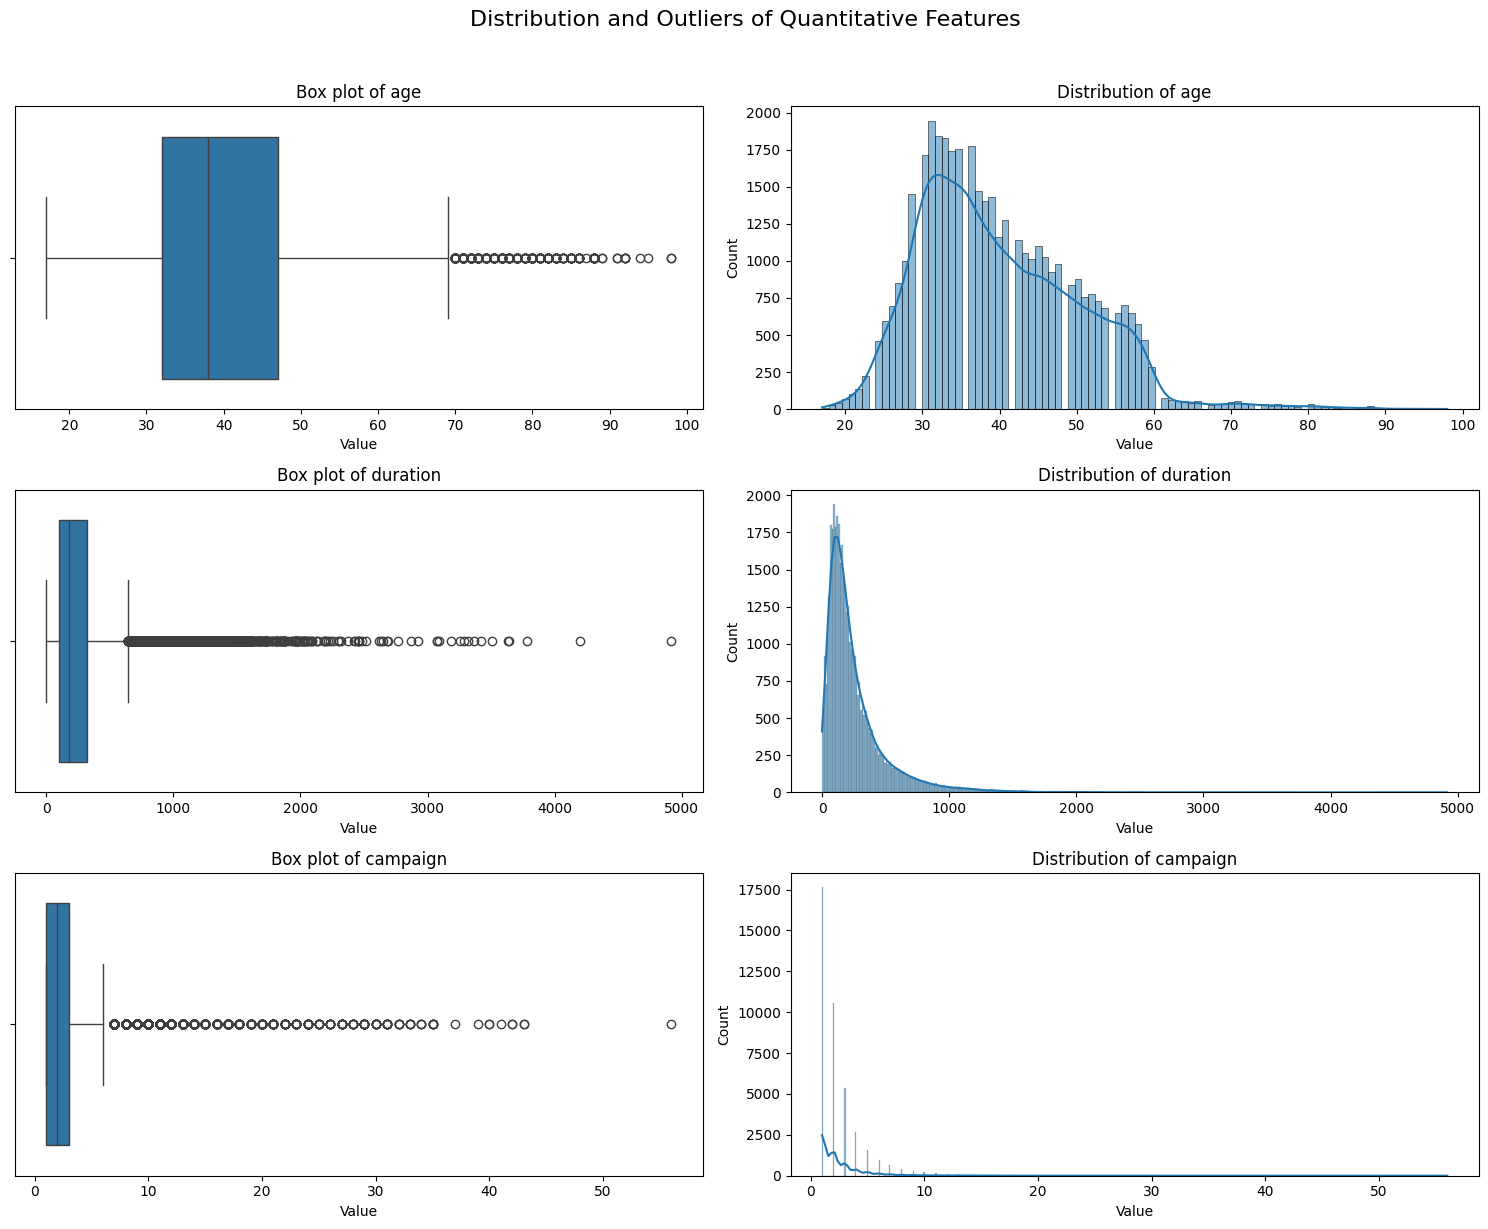

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

#@ Initial check of feature distribution

# List of quantitative features to check for outliers
quantitative_features = ['age','duration', 'campaign']

# Create box plots and histograms for each quantitative feature
fig, axes = plt.subplots(len(quantitative_features), 2, figsize=(15, 4*len(quantitative_features)))
fig.suptitle('Distribution and Outliers of Quantitative Features', fontsize=16, y=1.02)

for i, feature in enumerate(quantitative_features):
    # Box plot
    sns.boxplot(x=df[feature], ax=axes[i,0])
    axes[i,0].set_title(f'Box plot of {feature}')
    axes[i,0].set_xlabel('Value')
    
    # Histogram with KDE
    sns.histplot(df[feature], kde=True, ax=axes[i,1])
    axes[i,1].set_title(f'Distribution of {feature}')
    axes[i,1].set_xlabel('Value')

plt.tight_layout()
plt.show()

From the visualiazations which help us understand the data better, we see there are outliers. It is beneficial to filter outliers because of the KNN model's distance based algorithm.

In [44]:
#@ Remove outliers using IQR

# Print the shape of the dataset before removing outliers
print("Shape of the dataset before removing outliers: ", df.shape)

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each quantitative feature
for feature in quantitative_features:
    df = remove_outliers(df, feature)

# Print the shape of the dataset after removing outliers
print("Shape of the dataset after removing outliers: ", df.shape)

Shape of the dataset before removing outliers:  (41176, 22)
Shape of the dataset after removing outliers:  (35524, 22)


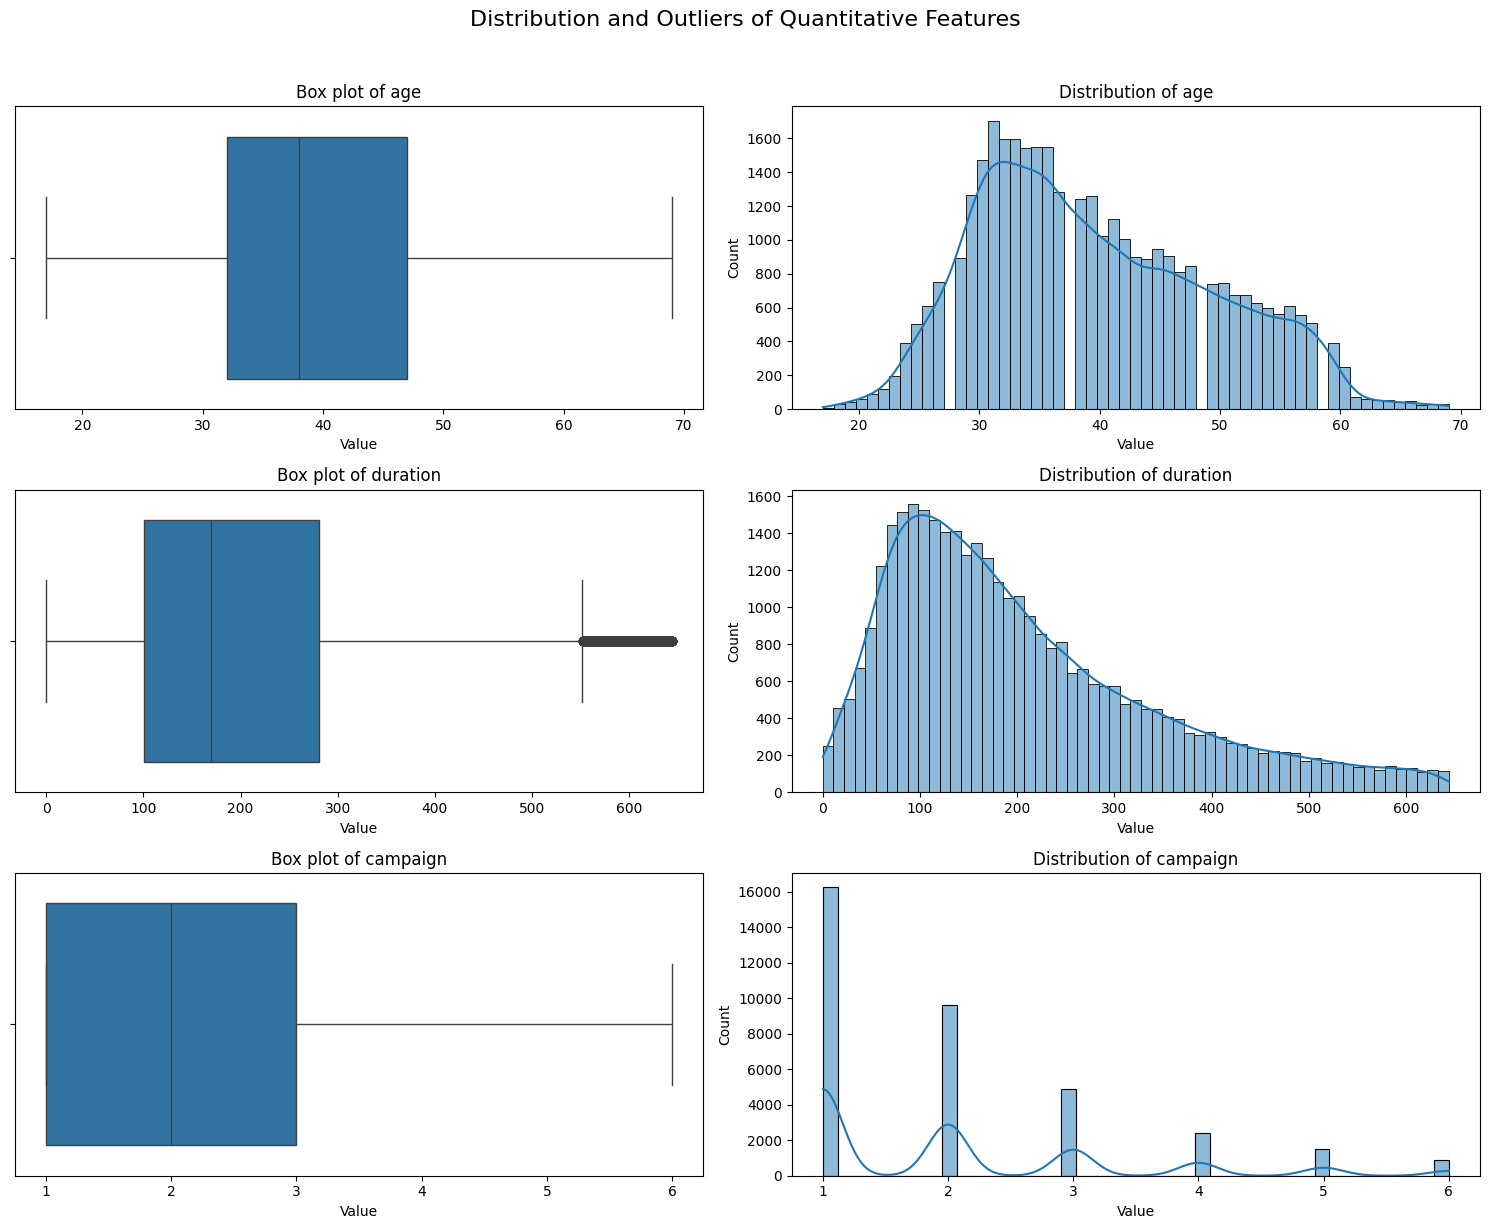

In [45]:
#@ Check for outliers again

# Create box plots and histograms for each quantitative feature
fig, axes = plt.subplots(len(quantitative_features), 2, figsize=(15, 4*len(quantitative_features)))
fig.suptitle('Distribution and Outliers of Quantitative Features', fontsize=16, y=1.02)

for i, feature in enumerate(quantitative_features):
    # Box plot
    sns.boxplot(x=df[feature], ax=axes[i,0])
    axes[i,0].set_title(f'Box plot of {feature}')
    axes[i,0].set_xlabel('Value')
    
    # Histogram with KDE
    sns.histplot(df[feature], kde=True, ax=axes[i,1])
    axes[i,1].set_title(f'Distribution of {feature}')
    axes[i,1].set_xlabel('Value')

plt.tight_layout()
plt.show()

In [49]:
df_encoded.head()

,age,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0,0,0,261,1,999,0,1.1,93.994,...,False,False,False,True,False,False,False,False,True,False
1,57,1,0,0,149,1,999,0,1.1,93.994,...,False,False,False,True,False,False,False,False,True,False
2,37,0,2,0,226,1,999,0,1.1,93.994,...,False,False,False,True,False,False,False,False,True,False
3,40,0,0,0,151,1,999,0,1.1,93.994,...,False,False,False,True,False,False,False,False,True,False
4,56,0,0,2,307,1,999,0,1.1,93.994,...,False,False,False,True,False,False,False,False,True,False


## Step 4: Scale the features (important for KNN)

Scaling is very importing in a KNN model since a KNN model is a distance based algorithm.

Let's scale the numerical variables in the Duration and Campaign features.

In [47]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

numerical_features = ['age']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Verify the scaling by checking mean (should be ~0) and std (should be ~1)
print("Scaled features statistics:")
print(df[numerical_features].describe())

Scaled features statistics:
                age
count  3.552400e+04
mean  -2.960261e-16
std    1.000014e+00
min   -2.335079e+00
25%   -7.852452e-01
50%   -1.653116e-01
75%    7.645889e-01
max    3.037679e+00


one-hot encoding increases dimensionality which can impact the KNN model's performance. Because of this, a dimenstionality reduction technique like PCA can help retain the most relevant information.

In [48]:
from sklearn.decomposition import PCA

# shape of the dataset before PCA
print("Shape of the dataset before PCA:", df_encoded.shape)

# Define the number of components to keep
n_components = 10

# Initialize PCA
pca = PCA(n_components=n_components)

# Separate features and target variable
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Print the explained variance ratio to see how much variance is captured by each component
print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

# Print the shape of the transformed data
print("Shape of the data after PCA:", X_pca.shape)

Shape of the dataset before PCA: (41176, 59)
Explained variance ratio by each component:
[6.26899571e-01 3.30920834e-01 4.08424786e-02 1.01314945e-03
 1.91157215e-04 6.95168105e-05 9.56513065e-06 8.38301951e-06
 4.85134425e-06 4.11806307e-06]
Shape of the data after PCA: (41176, 10)


## Step 3: Define features (X) and target (y)

## Step 5: Split into training and test sets (80 & 20)

## Step 6: Find the optimal K using 5-fold cross-validation

A small K can be noisy and sensitive to outliers, while a large K may smooth out patterns too much.

## Step 7: Plot the error rate for different K values

## Step 8: Find and print the optimal K (K with the minimum error rate)

## Step 9: Train the final KNN model with the optimal K

## Step 10: Make predictions

## Step 11: Model evaluation